In [1]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering

using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

In [2]:
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.

In [3]:
function normalizar1(xx::Array)
    norma=maximum(abs.(xx))
    result=xx./norma
    return result
end

normalizar1 (generic function with 1 method)

In [4]:
function filtraclusterchicos(puntos::Array, clustree, umbral)
    tabla=hcat(puntos,clustree)
    valores=unique(clustree)
    dd=Dict([(i,count(x->x==i,clustree)) for i in valores])
    predicado(j)=dd[j]>umbral
    result=tabla[map(x->predicado(x), clustree),:]
    (clusterfuck, cual)=findmax(dd)
    println("el cluster mayor tiene ",clusterfuck, " elementos, es el ", cual)
    return result
end

function filtraclusterchicos(puntos::Dict, umbral)
    # no solo aqui ya estan separados por dicctionario, sino tambien
    # en "electrodos", es decir numeros enteros
   result=Dict{Int, Set}()
    for k in keys(puntos)
        if length(puntos[k])>umbral
            result[k]=puntos[k]
        end
    end
    return result
end

filtraclusterchicos (generic function with 2 methods)

In [61]:
function declustaset(puntosyclust::Array; enteros=true)
    #= la funcion convierte el cluster en una tabla
    a un conjunto de enteros, sobre una malla 
    =#
    result=Dict{Int,Set}()
    clustnames=unique(puntosyclust[:,5])
    for q in clustnames
        subt=puntosyclust[puntosyclust[:,5].==q,:]
        if enteros
            punt=rowstoset(round.(Int64,subt[:,1:2]))
        else
            punt=rowstoset(subt[:,1:2])
        end    
        qindez=round(Int64,q)
        result[qindez]=punt
    end
    return result
end



declustaset (generic function with 1 method)

In [5]:
#funcion solo para plotear, no se si luego la vas a usar.
function dictatabla(dict::Dict)
    aux=[0 0 0]
    for q in keys(dict)
        aux2=[0 0]
        for renglon in dict[q]
            aux2=vcat(aux2, renglon)
        end
        (l,k)=size(aux2)
        columnaextra=ones(Int64, l).*q
        aux3=hcat(aux2, columnaextra)
        aux=vcat(aux, aux3)
    end
    return aux[2:end,:]
end

dictatabla (generic function with 1 method)

In [7]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [8]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

In [9]:
masamax=maximum(fruncio[:,3])

12329.550282478333

In [10]:
nmax=maximum(fruncio[:,4])

2000.0

In [12]:
function plot4Ddiscs(datos::Array)
    figure(figsize=(8,6.5))
    
    xx=datos[:,1]
    yy=datos[:,2]
    gordis=datos[:,3]
    nn=datos[:,4]
    
    xlim(0.0,65.0)
    ylim(0.0,65.0)
    
    
    scatter(xx,yy, s=0.25*gordis, edgecolors="darkmagenta", c=nn, cmap="plasma")
    colorbar()
end


plot4Ddiscs (generic function with 1 method)

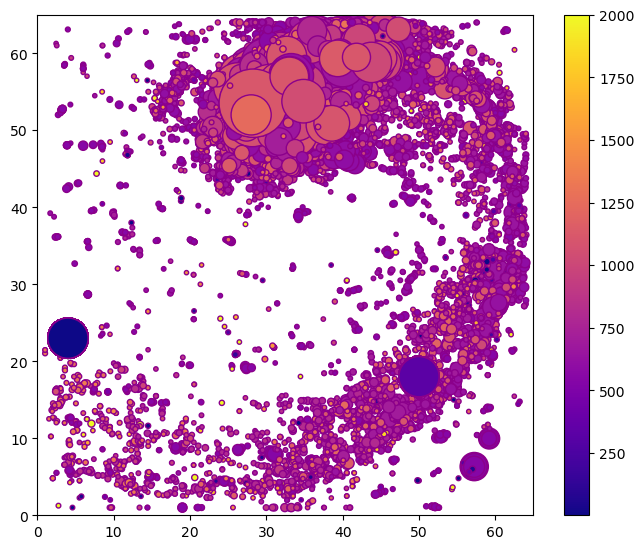

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd383f996d8>

In [13]:
plot4Ddiscs(fruncio)

In [17]:
nquantile(gordis, 10)

11-element Array{Float64,1}:
    36.039523124694824
    44.147528648376465
    50.51246871948242 
    57.95673894882202 
    69.36871032714845 
    85.28658199310303 
   111.60153331756585 
   188.7544267654419  
   574.7021411895752  
  3335.5237091064455  
 12329.550282478333   

In [54]:
frunciofiltrado=fruncio[fruncio[:,3].>50.153,:]
size(frunciofiltrado)

(7913, 4)

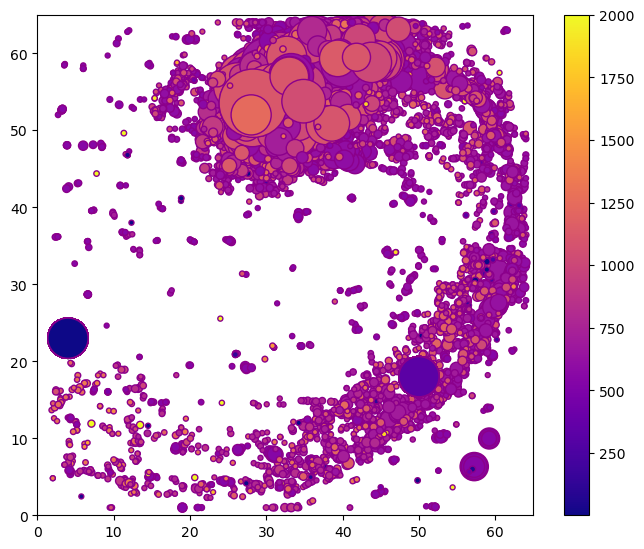

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd3844abcc0>

In [29]:
plot4Ddiscs(frunciofiltrado)


In [31]:
# clust1=fruncio[:,1:2];
clust1=permutedims(frunciofiltrado)

4×7913 Array{Float64,2}:
   49.9978    31.7893    10.2865   …    28.0012    44.7566    49.9984
   18.0004    60.9192     7.00301       51.9968    54.6292    17.9983
 3355.89      82.6364    81.8873      3339.65      85.3075  3345.59  
  306.0     1316.0     1316.0         1241.0     1241.0      322.0   

In [32]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64;

In [33]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×7913 Array{Float64,2}:
 49.9978  31.7893  10.2865   38.625   …  25.233   28.0012  44.7566  49.9984
 18.0004  60.9192   7.00301  63.6998     55.7956  51.9968  54.6292  17.9983
  9.792   42.112   42.112    42.656      39.712   39.712   39.712   10.304 

In [35]:
# decisiones, decisiones
dd4d=pairwise(Euclidean(), clust1, dims=2);
dd3d=pairwise(Euclidean(), clustspaciotiempo, dims=2);
dd2d=pairwise(Euclidean(), clust1[1:2,:], dims=2);

In [36]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

Hclust{Float64}([-1626 -2887; -2798 -5778; … ; -3726 7910; 4669 7911], [9.36836e-6, 1.08421e-5, 2.18722e-5, 2.27687e-5, 2.388e-5, 2.3899e-5, 2.3937e-5, 2.90832e-5, 3.26346e-5, 3.26485e-5  …  4.10906, 4.28125, 4.40309, 4.51158, 4.68463, 4.72579, 4.93391, 4.94627, 4.98157, 6.204], [5002, 851, 3792, 3726, 4559, 1872, 1352, 4545, 710, 3216  …  135, 5940, 3753, 657, 1107, 1518, 5130, 3306, 1076, 7160], :single)

In [37]:
hcorta=0.95 #estrictamente menos que un electrodo.
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [39]:
size(unique(clust4d))

(2417,)

In [43]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.5, c=clustn, cmap="inferno")
colorbar(fraction=0.045)
end

scatterclust (generic function with 1 method)

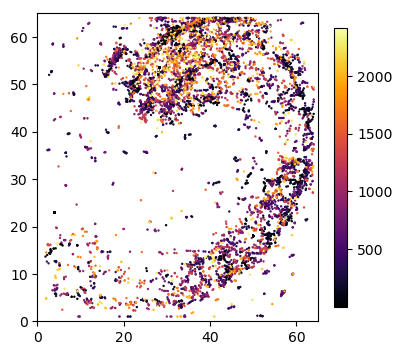

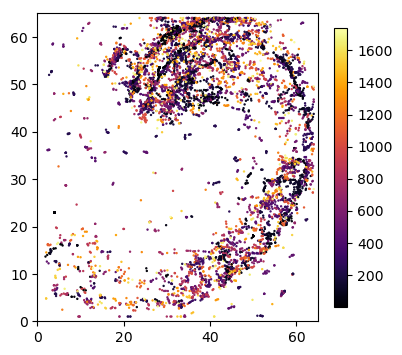

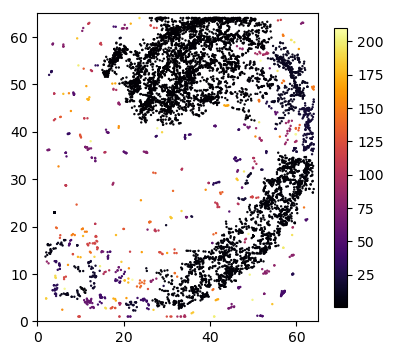

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd36579e550>

In [46]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [57]:
temp=hcat(frunciofiltrado, clust4d)
dict4d=declustasetenteros(temp)
blabla=filtraclusterchicos(dict4d, 1);

In [58]:
blatabla=dictatabla(blabla);

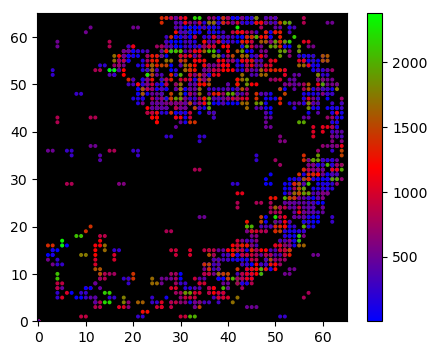

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd36559c0b8>

In [60]:
fafa=figure(figsize=(5,4))

ax=gca()
ax.set_facecolor("k")
axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(blatabla[:,1], blatabla[:,2], c=blatabla[:,3], s=3.5, cmap="brg")
colorbar()

In [ ]:
for q in keys(blabla) 
    println(q, " ", length(blabla[q]))
end

In [ ]:
decl=declustaset(blabla)

In [ ]:
decl[2]

In [ ]:
fafa=figure(figsize=(5,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
for q in keys(decl)
 print(q, " cubre ", length(decl[q]), "electrodos. \n")
end
#colorbar()

In [ ]:
pum=[0 0]
for q in decl[2]
    pum=vcat(pum, q)
end

In [ ]:
scatter(pum[:,1], pum[:,2])